# 基于生成式对抗网络的MCMC方法研究

## MCMC方法研究

MCMC(马氏链蒙特卡洛)是一种对高维随机向量抽样的方法， 此方法模拟一个马氏链， 使马氏链的平稳分布为目标分布， 由此产生大量的近似服从目标分布的样本，在实际使用时我们需要考虑合适的步长，既满足较高的接受率，且能从初始的位置转移到高概率的区域，因为在实际使用MCMC方法时，对于未知的分布我们很难去估计它的高概率区域的位置

## MH算法

MH算法根据随机在一定的区域游走，然后判断是否接受，从而获得服从原分布的样本

import各种库定义随机游走方差参数和迭代的次数

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
gamma=1
T=5000      #设置次数
T1=5000

定义多维概率密度函数

In [2]:
def func(x,y):
    z=np.exp(-10*(x**2-y)**2-(y-0.25)**4)
    return z

定义初始点和初始化用来存储样本点位置的向量

In [3]:
pi=np.zeros(shape=(T,2))
pi[0][0]=1.5
pi[0][1]=-0.75    #设置起始点

开始循环

In [4]:
t=0
while t < T-1:
    t = t + 1
    a=pi[t-1][0]
    b=pi[t-1][1]
    mean = np.array([a,b])              # 均值
    conv = np.array([[gamma**2, 0.0],        # 协方差矩阵
                 [0.0, gamma**2]])
    pi_star = np.random.multivariate_normal(mean=mean, cov=conv, size=1)
    alpha = min(1, (func(pi_star[0][0],pi_star[0][1]) / func(pi[t - 1][0],pi[t-1][1])))
    u = np.random.uniform(0, 1)
    if u < alpha:
        pi[t][0] = pi_star[0][0]
        pi[t][1] = pi_star[0][1]
        
    else:
        pi[t][0] = pi[t - 1][0]
        pi[t][1] = pi[t - 1][1]

为了计算接受率和接受点数，去除没有移动的点

In [5]:
t=1  

while t<T-1:
    if pi[t-1][0]==pi[t][0] and pi[t-1][0]==pi[t][0]:
        pi=np.delete(pi,t,0)
        t=t-1
        T=T-1
    t=t+1

pi_size=np.shape(pi)
print('接受点数：'+str(pi_size[0]))
print('接受率：'+str(pi_size[0]/T1*100)+'%')

接受点数：824
接受率：16.48%


将生成的抽样点画在概率密度函数的等高线上

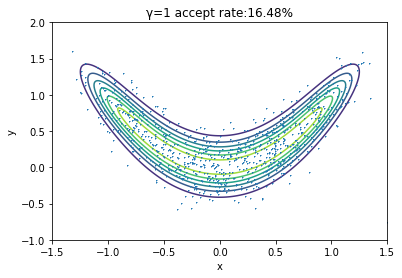

In [8]:
x=np.linspace(-1.5,1.5,1000)
y=np.linspace(-1,2,1000)
x1,y1=np.meshgrid(x,y)

plt.xlabel('x')
plt.ylabel('y')
plt.title('γ='+str(gamma)+' accept rate:'+str(round(pi_size[0]/T1*100,2))+'%')
plt.plot(pi[:,0],pi[:,1],'+',markersize=1)
plt.contour(x1,y1,func(x1,y1))
plt.show()

为了比较不同随机游走步长方差下的接受率和抽样情况，我们对MH算法迭代部分和作图部分进行封装

In [14]:
def mh(T,gamma,func):
    t=0
    pi=np.zeros(shape=(T,2))
    pi[0,0]=1.5
    pi[0,1]=-0.75    #设置起始点
    while t < T-1:
        t = t + 1
        a=pi[t-1,0]
        b=pi[t-1,1]
        mean = np.array([a,b])              # 均值
        conv = np.array([[gamma**2, 0.0],        # 协方差矩阵
                    [0.0, gamma**2]])
        pi_star = np.random.multivariate_normal(mean=mean, cov=conv, size=1)
        alpha = min(1, (func(pi_star[0,0],pi_star[0,1]) / func(pi[t - 1,0],pi[t-1,1])))
        u = np.random.uniform(0, 1)
        if u < alpha:
            pi[t,0] = pi_star[0,0]
            pi[t,1] = pi_star[0,1]
            
        else:
            pi[t,0] = pi[t - 1,0]
            pi[t,1] = pi[t - 1,1]
    rate=len(set(pi[:,0]))/(pi[:,0].size)
    print('接受率为'+str(round(rate*100,2))+'%')
    return pi,rate

画图部分：

In [53]:
def makefigure(pi,gamma,rate,func):
    x=np.linspace(-1.5,1.5,1000)
    y=np.linspace(-1,2,1000)
    x1,y1=np.meshgrid(x,y)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('γ='+str(gamma)+' accept rate:'+str(round(rate*100,2))+'%')
    plt.plot(pi[:,0],pi[:,1],'+',markersize=1)
    plt.contour(x1,y1,func(x1,y1))
    plt.show()

在密度函数为：
\begin{equation}
p(x,y)=\exp\{-10(x^2-y)^2-(y-0.25)^4\}
\end{equation}
下进行测试，首先测试$\sigma=0.01$时的情况

接受率为96.6%


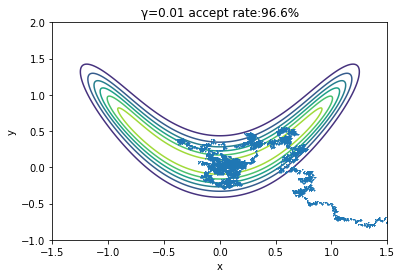

In [17]:
z=lambda x,y:np.exp(-10*(x**2-y)**2-(y-0.25)**4)
[pi,rate]=mh(5000,0.01,z)
makefigure(pi,0.01,rate,z)

小步长的情况下，可以看到接受率极高，但是会遇到难以从初始点转移到高概率区域的情形，下面测试$\sigma=0.1$的情况

接受率为79.3%


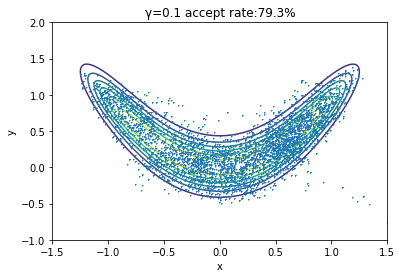

In [18]:
[pi,rate]=mh(5000,0.1,z)
makefigure(pi,0.1,rate,z)

接受率有所下降，但算法产生的样本点大多都在高概率区域，和原先概率密度也较为接近，成功的从初始点转移到高概率区域，下面测试$\sigma=0.5$的情况

接受率为33.56%


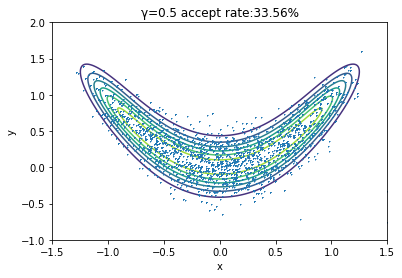

In [19]:
[pi,rate]=mh(5000,0.5,z)
makefigure(pi,0.5,rate,z)

大多数点在高概率区域，但由于步长过大，接受率急剧下降，算法效率较低

同样MH算法会在多个概率密度峰值的情况下，集中在一个高概率区域，难以转移到另一个高概率区域
\begin{equation}
F(x,y)=\log\{(1-x)^2+100(y-x^2)^2\}\\
p(x,y)=\exp\{-\frac{(F(x,y)-4)^2}{2\cdot0.3^2}\}\cdot\exp\{-\frac{x^2+y^2}{2}\}
\end{equation}

接受率为61.28%


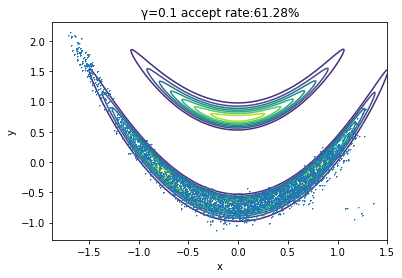

In [47]:
F=lambda x,y:np.log((1-x)**2+100*(y-x**2)**2)
z=lambda x,y:np.exp(-((F(x,y)-4)**2)/(2*0.3**2))*np.exp(-(x**2+y**2)/2)
[pi,rate]=mh(5000,0.1,z)
makefigure(pi,0.1,rate,z)

混合高斯的情形
\begin{equation}
p(x,y)=\exp\{-\frac{(x-3)^2+y^2}{2}\}+\exp\{-\frac{(x+3)^2+y^2}{2}\}
\end{equation}

接受率为94.54%


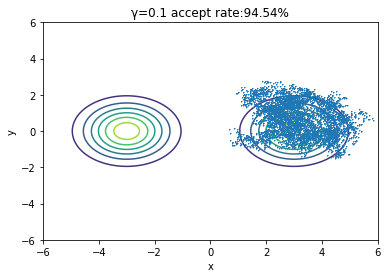

In [54]:
z=lambda x,y:np.exp(-((x-3)**2+y**2)/2)+np.exp(-((x+3)**2+y**2)/2)
[pi,rate]=mh(5000,0.1,z)
makefigure(pi,0.1,rate,z)

因此，我们需要一个更加优秀的算法，兼顾接受率和样本点大多分布在高概率区域，且可以在多个高概率区域之间转移的算法

## HMC算法

通过改变MH算法中的随机游走策略，把分布的高概率区域和Hamilton方程中的高概率区域结合起来，把样本点的游走和物体的Hamilton方程中的动量结合起来，使用leapfrog方法解Hamilton方程得到样本点的游走轨迹，保留位置参数，然后根据MCMC方法来判断是否接受这个样本点，从而得到抽取的样本点

首先，Import各种函数库

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import matplotlib.animation as animation

定义密度函数并对密度函数（p）取负对数，使用python符号运算求梯度
\begin{equation}
grad(-ln(p(x,y)))
\end{equation}

In [3]:
fun=lambda x,y:np.exp(-10*(x**2-y)**2-(y-0.25)**4)#概率密度函数

x,y=sp.symbols('x,y')
prob=sp.exp(-10*(x**2-y)**2-(y-0.25)**4)
U=-sp.log(prob)
Ux=sp.diff(U,x)
Uy=sp.diff(U,y)
gradU=np.vectorize(sp.lambdify([x,y],[Ux,Uy],'numpy'))#把求导结果转化为匿名函数
U=sp.lambdify([x,y],U,'numpy')

定义迭代次数，产生随机动量正态分布随机数的$\sigma$及初始化向量组

In [4]:
Mass=1
iterations=5000
stepsize=0.01
p=np.zeros([iterations,2])
q=np.zeros([iterations,2])
q[0,:]=[-1.5,0.75]

定义最关键的HMC迭代函数，从上一个位置点得到下一个位置点

In [5]:
def HMC(U1,grad_U,epsilon,L,current_q):
    q = current_q
    p = np.random.normal(0,1,q.shape)
    current_p = p
    p = p - (epsilon/2) * grad_U(q[0],q[1])

    for i in range(1,L):
        q = q + epsilon * p
        if i!=L-1:
            p = p - epsilon * grad_U(q[0],q[1])
    
    p = p - (epsilon/2) * grad_U(q[0],q[1])
    p = -p
    current_U=U1(current_q[0],current_q[1])
    current_K=np.sum(current_p**2)/2
    proposed_U=U1(q[0],q[1])
    proposed_K=np.sum(p**2)/2

    if np.random.uniform(0,1)<np.min([1,np.exp(current_U-proposed_U+current_K-proposed_K)]):
        return q
    else:
        return current_q

进行迭代计算样本点，并计算接受率

In [6]:
for i in range(1,iterations):
    q[i,:]=HMC(U,gradU,stepsize,20,q[i-1,:])

accept_rate=len(set(q[:,1]))/q.shape[0]
print(accept_rate)

0.9986


作图直观地了解抽样点的分布情况

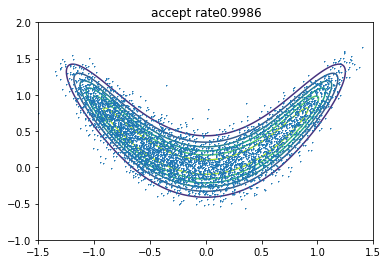

In [7]:
x1=np.linspace(-1.5,1.5,1000)
y1=np.linspace(-1,2,1000)
[X,Y]=np.meshgrid(x1,y1)
plt.title('accept rate'+str(accept_rate))
plt.contour(X,Y,fun(X,Y))
plt.plot(q[:,0],q[:,1],'+',markersize=1)
plt.show()

HMC能够兼顾较高的接受率和从初始位置转移到高概率区域的能力，下面测试不同分布函数时的情况，定义封装测试函数

In [12]:
def stution(fun):
    Mass=1
    iterations=5000
    stepsize=0.03
    p=np.zeros([iterations,2])
    q=np.zeros([iterations,2])
    q[0,:]=[-1.5,0.75]
    x,y=sp.symbols('x,y')
    prob=fun
    U=-sp.log(prob)
    Ux=sp.diff(U,x)
    Uy=sp.diff(U,y)
    gradU=np.vectorize(sp.lambdify([x,y],[Ux,Uy],'numpy'))#把求导结果转化为匿名函数
    U=sp.lambdify([x,y],U,'numpy')
    fun=sp.lambdify([x,y],prob,'numpy')
    for i in range(1,iterations):
        q[i,:]=HMC(U,gradU,stepsize,20,q[i-1,:])

    accept_rate=len(set(q[:,1]))/q.shape[0]
    print(accept_rate)
    x1=np.linspace(-8,8,1000)
    y1=np.linspace(-3,3,1000)
    [X,Y]=np.meshgrid(x1,y1)
    plt.title('accept rate'+str(accept_rate))
    plt.contour(X,Y,fun(X,Y))
    plt.plot(q[:,0],q[:,1],'+',markersize=1)
    plt.show()

<lambdifygenerated-50>:2: RuntimeWarning: overflow encountered in exp
  return ([-(-x*exp(-1/2*x**2 - 1/2*y**2)*exp(-34.7222222222222*(0.4*log((1 - x)**2 + 100*(-x**2 + y)**2) - 1)**2) - 27.7777777777778*(0.4*log((1 - x)**2 + 100*(-x**2 + y)**2) - 1)*(-400*x*(-x**2 + y) + 2*x - 2)*exp(-1/2*x**2 - 1/2*y**2)*exp(-34.7222222222222*(0.4*log((1 - x)**2 + 100*(-x**2 + y)**2) - 1)**2)/((1 - x)**2 + 100*(-x**2 + y)**2))*exp((1/2)*x**2 + (1/2)*y**2)*exp(34.7222222222222*(0.4*log((1 - x)**2 + 100*(-x**2 + y)**2) - 1)**2), -(-y*exp(-1/2*x**2 - 1/2*y**2)*exp(-34.7222222222222*(0.4*log((1 - x)**2 + 100*(-x**2 + y)**2) - 1)**2) - 27.7777777777778*(-200*x**2 + 200*y)*(0.4*log((1 - x)**2 + 100*(-x**2 + y)**2) - 1)*exp(-1/2*x**2 - 1/2*y**2)*exp(-34.7222222222222*(0.4*log((1 - x)**2 + 100*(-x**2 + y)**2) - 1)**2)/((1 - x)**2 + 100*(-x**2 + y)**2))*exp((1/2)*x**2 + (1/2)*y**2)*exp(34.7222222222222*(0.4*log((1 - x)**2 + 100*(-x**2 + y)**2) - 1)**2)])
<lambdifygenerated-50>:2: RuntimeWarning: invalid value

0.914


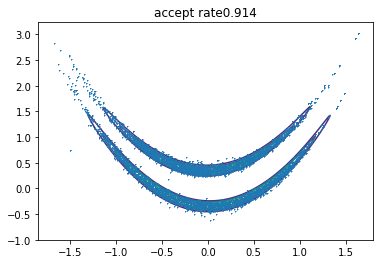

In [97]:
x,y=sp.symbols('x,y')
F=sp.log((1-x)**2+100*(y-x**2)**2)
z=sp.exp(-((F-2.5)**2)/(2*0.3**2))*sp.exp(-(x**2+y**2)/2)
stution(z)

可在适当放大步长牺牲接受率的情况下转移到另一个高概率分布区域

1.0


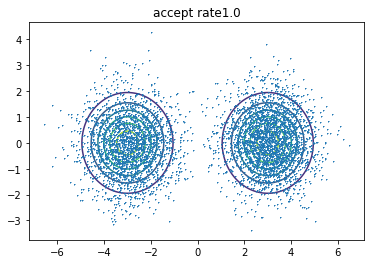

In [10]:
x,y=sp.symbols('x,y')
z=sp.exp(-((x-3)**2+y**2)/2)+sp.exp(-((x+3)**2+y**2)/2)
stution(z)

同样可以在混合高斯型函数下保持转移能力和较高的接受率，我们在不同参数下的混合高斯分布继续测试HMC算法的表现

1.0


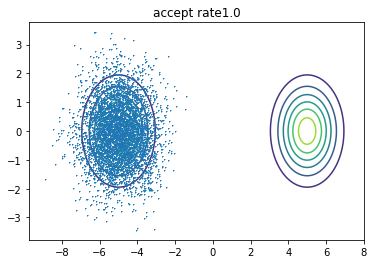

In [13]:
x,y=sp.symbols('x,y')
z=sp.exp(-((x-5)**2+y**2)/2)+sp.exp(-((x+5)**2+y**2)/2)
stution(z)

但在非常极端的条件下，两个概率密度峰值点距离极远时，HMC方法也无法转移到另一个高概率区域

## 基于Tensorflow平台的GAN神经网络实现

### import tensorflow和其他package

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.__version__

'2.1.0'

可以使用如下命令安装与GIF生成有关的package
<center><mark>!pip install -q imageio <mark>

但由于jupyter安装的环境混乱，放弃使用

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### 加载和准备数据集

将使用MNIST数据集训练生成器和判别器,由于需要翻qiang，这里先把数据集下载下来，然后读取

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data('C:\\Users\\xr chen\\Downloads\\mnist.npz')
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 将图片标准化到 [-1, 1] 区间内
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# 批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 创建模型
#### 生成器
生成器使用 tf.keras.layers.Conv2DTranspose （上采样）层来从种子（随机噪声）中产生图片。以一个使用该种子作为输入的 Dense 层开始，然后多次上采样直到达到所期望的 28x28x1 的图片尺寸。注意除了输出层使用 tanh 之外，其他每层均使用 tf.keras.layers.LeakyReLU 作为激活函数。

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 注意：batch size 没有限制

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

使用尚未训练的生成器创建一张照片

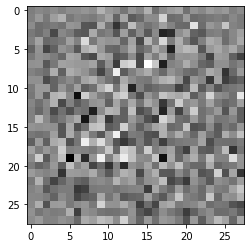

In [19]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### 判别器
一个基于CNN的图片分类器

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

使用尚未训练的判别器判断真伪，真实图片输出正值，虚假图片输出负值

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00070126]], shape=(1, 1), dtype=float32)


### 定义损失函数和优化器
为两个模型定义损失函数和优化器

In [9]:
# 该方法返回计算交叉熵损失的辅助函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### 判别器损失
量化判别器的判断能力，它将判别器对真实图片的预测值与值全为 1 的数组进行对比，将判别器对伪造（生成的）图片的预测值与值全为 0 的数组进行对比。

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### 生成器损失
生成器损失量化其欺骗判别器的能力。直观来讲，如果生成器表现良好，判别器将会把伪造图片判断为真实图片（或 1）。这里我们将把判别器在生成图片上的判断结果与一个值全为 1 的数组进行对比。

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

由于我们需要分别训练两个网络，判别器和生成器的优化器是不同的。

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### 保存检查点
本笔记还演示了如何保存和恢复模型，这在长时间训练任务被中断的情况下比较有帮助。

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 定义训练循环

In [14]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


# 我们将重复使用该种子（因此在动画 GIF 中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate, noise_dim])

训练循环在生成器接收到一个随机种子作为输入时开始。该种子用于生产一张图片。判别器随后被用于区分真实图片（选自训练集）和伪造图片（由生成器生成）。针对这里的每一个模型都计算损失函数，并且计算梯度用于更新生成器与判别器。

In [15]:
# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # 继续进行时为 GIF 生成图像
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 每 15 个 epoch 保存一次模型
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 最后一个 epoch 结束后生成图片
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

#### 生成与保存图片

In [17]:
def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### 训练模型
调用上面定义的 train() 方法来同时训练生成器和判别器。注意，训练 GANs 可能是棘手的。重要的是，生成器和判别器不能够互相压制对方（例如，他们以相似的学习率训练）。
在训练之初，生成的图片看起来像是随机噪声。随着训练过程的进行，生成的数字将越来越真实。在大概 50 个 epoch 之后，这些图片看起来像是 MNIST 数字。使用 Colab 中的默认设置可能需要大约 1 分钟每 epoch。

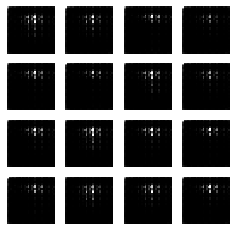

Wall time: 14min 38s


In [18]:
%%time
#train(train_dataset, EPOCHS)#时间太长
train(train_dataset,1)